# Concrete Mathic 🤖🪄

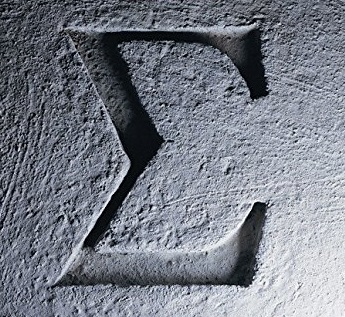

In [1]:
from IPython.display import Image
Image(filename='pics/mathic.jpg', width=400 , height=400 )

## 💾 The data

#### Compressive strength data:
- "cement" - Portland cement in kg/m3
- "slag" - Blast furnace slag in kg/m3
- "fly_ash" - Fly ash in kg/m3
- "water" - Water in liters/m3
- "superplasticizer" - Superplasticizer additive in kg/m3
- "coarse_aggregate" - Coarse aggregate (gravel) in kg/m3
- "fine_aggregate" - Fine aggregate (sand) in kg/m3
- "age" - Age of the sample in days
- "strength" - Concrete compressive strength in megapascals (MPa)

***Acknowledgments**: I-Cheng Yeh, "Modeling of strength of high-performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)*.

In [2]:
import pandas as pd
df = pd.read_csv('data/concrete_data.csv')
display(df.head())

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## The average strength 🦾

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

$$ Average \ Strength \ for \ 1, \ 7, \ 14 \ and \ 28 \ days \ of \ age $$

In [4]:
df_avg_str_sel = df[['strength', 'age']]
df_avg_str = df_avg_str_sel.groupby('age').mean().reset_index()
df_avg_s = df_avg_str[df_avg_str['age'] == 1].append(df_avg_str[df_avg_str['age'] == 7]).append(df_avg_str[df_avg_str['age'] == 14]).append(df_avg_str[df_avg_str['age'] == 28])
display(df_avg_s.rename({'strength' : 'avg. strength'}, axis=1).set_index('age').T)

age,1,7,14,28
avg. strength,9.452716,26.050623,28.751038,36.74848


## 🧮 Coefficients

Let's take a short look on the dataset correlation:

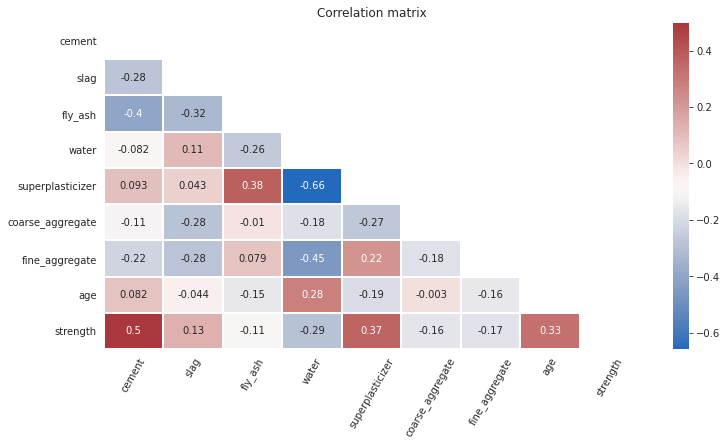

In [5]:
df_corr = df.corr()
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, heatmap = plt.subplots(figsize=(12, 6))
    heatmap = sns.heatmap(df_corr, cmap="vlag", mask=mask, linewidths=1, annot=True).set(title='Correlation matrix')
plt.xticks(rotation=60)
plt.show()

We need to find the coefficients for the formula:<br>
<br>
$$ Concrete \ Strength = \beta_{0} \ + \ \beta_{1}*cement \ + \ \beta_{2}*slag \ + \ \beta_{3}*fly \ ash  \ + \ \beta_{4}*water \ + $$ 
$$ \beta_{5}*superplasticizer \ + \ \beta_{6}*coarse \ aggregate \ + \ \beta_{7}*fine \ aggregate \ + \ \beta_{8}*age $$

## 🤖🪄 Developing a machine learning model for find the coefficients:

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


X = df[['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']]

y = df[['strength']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)

rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, random_state=120)
rf.fit(X_train, y_train)
rf_confidence = rf.score(X_test, y_test)

gbr = GradientBoostingRegressor(n_estimators=600, max_depth=30, min_samples_split = 60, learning_rate=0.1, random_state=120)
gbr.fit(X_train, y_train)
gbr_confidence = gbr.score(X_test, y_test)


names = ['Random Forest', 'Gradient Boosting']
columns = ['Model', 'Accuracy']
scores = [rf_confidence, gbr_confidence]
score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
display(score)


,Model,Accuracy
0,Random Forest,0.902211
1,Gradient Boosting,0.934236


In [7]:
print('Random Forest Coefficients: ', rf.feature_importances_)
print('Gradient Boosting Coefficients: ', gbr.feature_importances_)


Random Forest Coefficients:  [0.31205013 0.07825432 0.02209182 0.13480212 0.06225045 0.02769354
 0.03315855 0.32969907]
Gradient Boosting Coefficients:  [0.3234595  0.08356639 0.01692405 0.0978801  0.08920785 0.02411301
 0.02969942 0.33514968]


### Checking 🔎

Both the models gieves nearble equal coefficients, but because the Gradient Boosting predictive acciracy is higher, we'll use its coefficients for 

In [8]:

b1, b2, b3, b4, b5, b6, b7, b8 = gbr.feature_importances_
b0=0
display(b1, b2, b3, b4, b5, b6, b7, b8)

0.3234594969155106

0.08356639453443178

0.016924045705257768

0.09788010038611196

0.08920784739408398

0.024113007798037517

0.0296994246133663

0.3351496826532

In [9]:
df['strength_test'] = b0 + (b1 * df['cement']) + (b2 * df['slag']) + (b3 * df['fly_ash']) + (b4 * df['water']) + (b5 * df['superplasticizer']) + (b6 * df['coarse_aggregate']) + (b7 * df['fine_aggregate']) + (b8 * df['age'])


In [10]:
print('Standard Deviation of test: ', df['strength_test'].std())
df['diff_str'] = df['strength'] - df['strength_test']
print('Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: ')
print('Mean: ', df['diff_str'].mean())
print('Median: ', df['diff_str'].median())
print('Standard Deviation: ', df['diff_str'].std())

Standard Deviation of test:  38.8534693199313
Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: 
Mean:  -142.28369400724563
Median:  -136.29389837518298
Standard Deviation:  31.661673039748084


In [11]:
b0=-140
print('The b0 coefficient should be around', b0, 'for set Mean and Median of Difference near the 0')

df['strength_test'] = b0 + (b1 * df['cement']) + (b2 * df['slag']) + (b3 * df['fly_ash']) + (b4 * df['water']) + (b5 * df['superplasticizer']) + (b6 * df['coarse_aggregate']) + (b7 * df['fine_aggregate']) + (b8 * df['age'])
df['diff_str'] = df['strength'] - df['strength_test']
print('Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: ')
print('Mean: ', df['diff_str'].mean())
print('Median: ', df['diff_str'].median())
print('Standard Deviation: ', df['diff_str'].std())

The b0 coefficient should be around -140 for set Mean and Median of Difference near the 0
Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: 
Mean:  -2.283694007245628
Median:  3.7061016248170233
Standard Deviation:  31.66167303974808


In [12]:
display(df[['strength', 'strength_test', 'diff_str']][:20].T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
strength,79.986111,61.887366,40.269535,41.052780,44.296075,47.029847,43.698299,36.447770,45.854291,39.289790,38.074244,28.021684,43.012960,42.326932,47.813782,52.908320,39.358048,56.141962,40.563252,42.620648
strength_test,105.286254,105.647950,132.380353,164.219572,122.859154,50.418867,175.614495,62.669052,29.639587,85.458897,32.368739,11.589459,155.170197,32.186991,38.755525,77.766681,20.820984,160.816906,83.448332,136.401648
diff_str,-25.300144,-43.760584,-92.110817,-123.166792,-78.563079,-3.389020,-131.916195,-26.221282,16.214704,-46.169107,5.705504,16.432225,-112.157237,10.139940,9.058257,-24.858361,18.537064,-104.674944,-42.885080,-93.781000


But it shows terrible digits in direct check...

## Second Try with LazyRegressor 🦥
I found some magic to try
# 🧙🏻🪄 

''' but while it works in Workspace, I can't make it work during the publication process... the code is below and it's output as a picture after it '''

!pip install lazypredict <br>
<br>
import lazypredict <br>
from lazypredict.Supervised import LazyRegressor <br>
<br>
lreg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None) <br>
<br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=120) <br>
<br>
models, pred = lreg.fit(X_train, X_test, y_train, y_test) <br>
<br>
display(models.head(15))

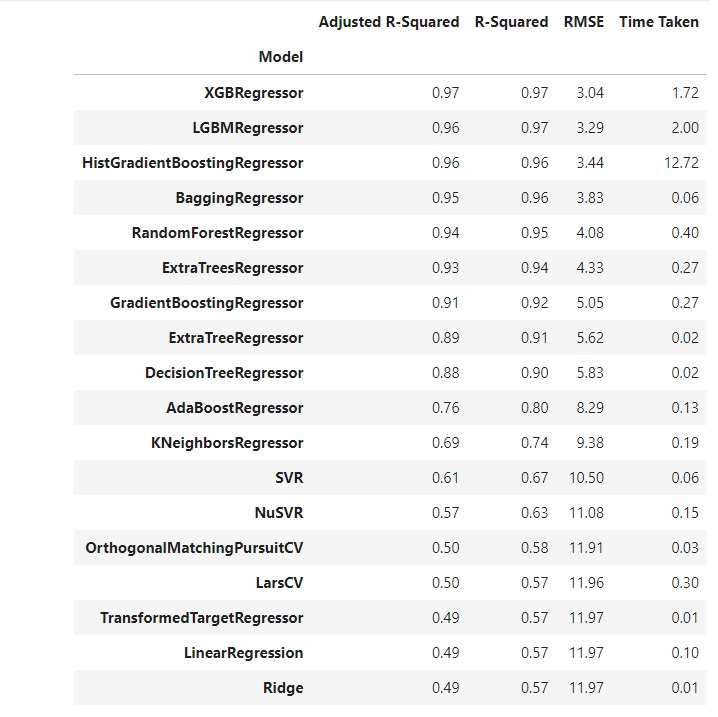

In [13]:
Image(filename='pics/regressors.jpg', width=500 , height=500 )

#### 🪄🦥 The Lazy thing says that the best model should be the XGBRegressor 
Let's try it:

In [14]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=120)

xgbr.fit(X_train, y_train)

print("XGBRegressor's test score: ", xgbr.score(X_test, y_test))

print("XGBRegressor's coefficients: ", xgbr.feature_importances_)

XGBRegressor's test score:  0.9725764390141047
XGBRegressor's coefficients:  [0.22442004 0.12193549 0.04585698 0.12231112 0.1724411  0.03089933
 0.05444155 0.2276944 ]


In [15]:
# unpacking the coefficients into the variables
b1, b2, b3, b4, b5, b6, b7, b8 = xgbr.feature_importances_
b0=0
display(b1, b2, b3, b4, b5, b6, b7, b8)

0.22442004

0.121935494

0.04585698

0.12231112

0.1724411

0.030899331

0.054441545

0.2276944

In [16]:
# pythoning the formula
df['strength_XGBR'] = b0 + (b1 * df['cement']) + (b2 * df['slag']) + (b3 * df['fly_ash']) + (b4 * df['water']) + (b5 * df['superplasticizer']) + (b6 * df['coarse_aggregate']) + (b7 * df['fine_aggregate']) + (b8 * df['age'])

In [17]:
print('Standard Deviation of test: ', df['strength_XGBR'].std())
df['diff_str'] = df['strength'] - df['strength_XGBR']
print('Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: ')
print('Mean: ', df['diff_str'].mean())
print('Median: ', df['diff_str'].median())
print('Standard Deviation: ', df['diff_str'].std())

Standard Deviation of test:  24.635462754931122
Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: 
Mean:  -144.62834034942088
Median:  -141.9557887369109
Standard Deviation:  18.73798781847893


In [18]:
b0=-143
print('The b0 coefficient should be around', b0, 'for set Mean and Median of Difference near the 0')

df['strength_XGBR'] = b0 + (b1 * df['cement']) + (b2 * df['slag']) + (b3 * df['fly_ash']) + (b4 * df['water']) + (b5 * df['superplasticizer']) + (b6 * df['coarse_aggregate']) + (b7 * df['fine_aggregate']) + (b8 * df['age'])
print('Standard Deviation of test: ', df['strength_XGBR'].std())
df['diff_str'] = df['strength'] - df['strength_XGBR']
print('Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: ')
print('Mean: ', df['diff_str'].mean())
print('Median: ', df['diff_str'].median())
print('Standard Deviation: ', df['diff_str'].std())
display(df[['strength', 'strength_XGBR', 'diff_str']][:20].T)

The b0 coefficient should be around -143 for set Mean and Median of Difference near the 0
Standard Deviation of test:  24.635462754931122
Difference between the original data of strength and the data of strength calculated by using coefficients from the prediction model in the formula: 
Mean:  -1.6283403494209014
Median:  1.0442112630890907
Standard Deviation:  18.73798781847893


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
strength,79.986111,61.887366,40.269535,41.05278,44.296075,47.029847,43.698299,36.447770,45.854291,39.289790,38.074244,28.021684,43.012960,42.326932,47.813782,52.90832,39.358048,56.141962,40.563252,42.620648
strength_XGBR,73.745559,74.209049,99.496352,121.12732,98.341203,44.249822,125.995336,49.262321,30.132768,58.998353,36.863713,22.746659,109.232384,36.460996,34.027181,55.93306,34.119045,114.654609,63.379374,93.607903
diff_str,6.240552,-12.321683,-59.226816,-80.07454,-54.045128,2.780026,-82.297037,-12.814551,15.721523,-19.708563,1.210531,5.275024,-66.219423,5.865936,13.786601,-3.02474,5.239003,-58.512647,-22.816122,-50.987255


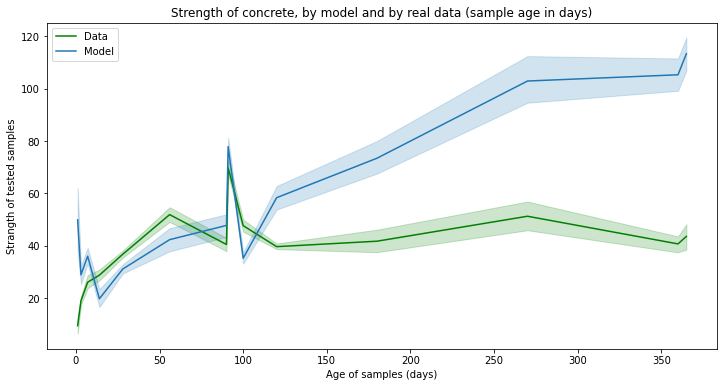

In [19]:
ax1, ax2 = plt.subplots(figsize=(12, 6))
ax1 = sns.lineplot(data=df, x='age', y='strength', color='green', label='Data')
ax2 = sns.lineplot(data=df, x='age', y='strength_XGBR', label='Model')

plt.title('Strength of concrete, by model and by real data (sample age in days)')
plt.xlabel('Age of samples (days)')
plt.ylabel('Strangth of tested samples')
plt.show()

Looks like the model expects that our concrete should be stronger with the time more than that really is.

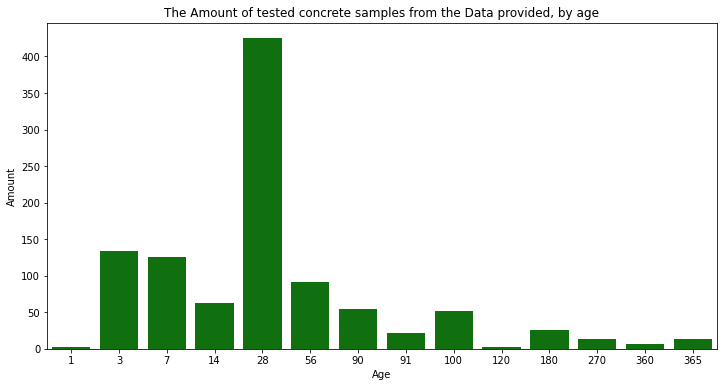

In [20]:
df_count_age = df.groupby('age').count()

ax1 = plt.subplots(figsize=(12, 6))
ax1 = sns.barplot(data=df_count_age, x=df_count_age.index, y = 'slag', color="green")
plt.title('The Amount of tested concrete samples from the Data provided, by age')
plt.ylabel('Amount')
plt.xlabel('Age')
plt.show()

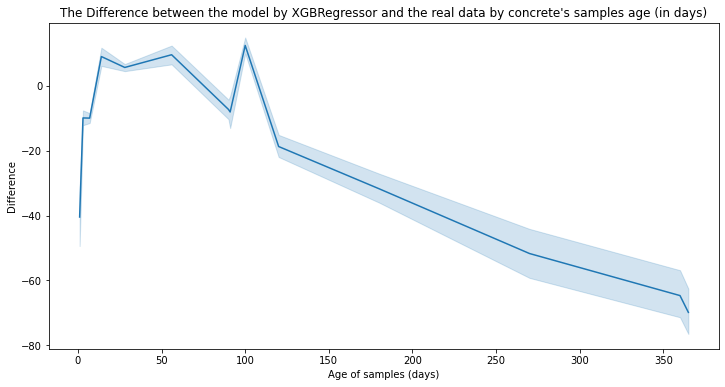

In [21]:
ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df, x='age', y='diff_str')
plt.title("The Difference between the model by XGBRegressor and the real data by concrete's samples age (in days)")
plt.xlabel('Age of samples (days)')
plt.ylabel('Difference')
plt.show()

In [22]:
print('The Difference are below 1 in :', (df[(df['diff_str'] >= -1) & (df['diff_str'] <= 1)])['diff_str'].count(), 'of samples')

The Difference are below 1 in : 53 of samples


In [23]:
print('The Difference are below 3.5 in :', (df[(df['diff_str'] >= -3.5) & (df['diff_str'] <= 3.5)])['diff_str'].count(), 'of samples')
print('The Difference are below 4 in :', (df[(df['diff_str'] >= -4) & (df['diff_str'] <= 4)])['diff_str'].count(), 'of samples')
print('The Difference are below 6 in :', (df[(df['diff_str'] >= -6) & (df['diff_str'] <= 6)])['diff_str'].count(), 'of samples')
print('The Difference are below 8 in :', (df[(df['diff_str'] >= -8) & (df['diff_str'] <= 8)])['diff_str'].count(), 'of samples')
print('The Difference are below 12 in :', (df[(df['diff_str'] >= -12) & (df['diff_str'] <= 12)])['diff_str'].count(), 'of samples')
print('The Difference are below 16 in :', (df[(df['diff_str'] >= -16) & (df['diff_str'] <= 16)])['diff_str'].count(), 'of samples')
print('The Difference are below 24 in :', (df[(df['diff_str'] >= -24) & (df['diff_str'] <= 24)])['diff_str'].count(), 'of samples')
print('Of the total', df['diff_str'].count(), 'samples')

The Difference are below 3.5 in : 163 of samples
The Difference are below 4 in : 189 of samples
The Difference are below 6 in : 287 of samples
The Difference are below 8 in : 382 of samples
The Difference are below 12 in : 558 of samples
The Difference are below 16 in : 715 of samples
The Difference are below 24 in : 886 of samples
Of the total 1030 samples


## 🤓 Conclusion
Model of the reality are not an ideal copy of the reality.<br>
The best model are still gives difference.

## Future noodles 🍜
We <b>need</b> to receive <b>more data</b> during the future the team's testing of the concrete for improve our model performance by training results of tested concrete samples on the bigger data.

# The End 🪄

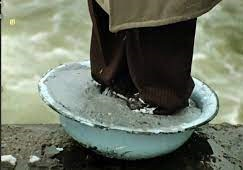

In [24]:
Image(filename='pics/the_end.jpg', width=300 , height=300 )